# Команда TEAM DREAM
**Состав комады:**
- Рыжков Максим (TM, PM, DA)
- Ли Сюань Линь
- Халиков Рифат Шавкатович (DA)
- Карманов Максим
- Буржимский Сергей Александрович (ML)
- Перминов Артем Александрович (ML, PM)

# КЕЙС №8 "Прогнозирование стоимости компании"
**Краткое описание кейса:**

Требуется определить стоимость кампании на основе косвенных признаков, таких как финансовые показатели, количество сотрудников, рыночная доля и другие факторы.

**Ожидаемый результат:**

Обученная модель регрессии, предсказывающая стоимость кампании по данным.

**Основной функционал:**
  - Сбор и подготовка данных (финансовые отчёты, рыночные данные)
  - Применение корреляционного анализа для выявления взаимосвязей между признаками и стоимостью
  - Построение регрессионных моделей (линейная регрессия, градиентный бустинг)
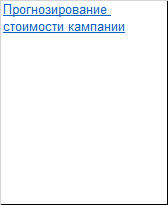

# Импорт библиотек

In [10]:
import pandas as pd                                     # для работы с таблицами (как Excel в коде)
import numpy as np                                      # для математических операций
import matplotlib.pyplot as plt                         # для графиков
import seaborn as sns                                   # для красивых графиков
from sklearn.model_selection import train_test_split    # для разделения данных
from sklearn.preprocessing import StandardScaler        # для нормализации данных
from sklearn.linear_model import LinearRegression       # простая модель
from sklearn.ensemble import GradientBoostingRegressor  # сложная модель
from sklearn.metrics import mean_squared_error, mean_absolute_error  # для оценки качества

# Загрузка данных

In [11]:
financials_csv = pd.read_csv('../data/financials.csv', usecols=lambda column: column != "Symbol") # выгружаем данные и удаляем Symbol (это просто идентификатор)

# Первичный анализ данных

In [12]:
print("Информация о данных:")
print(financials_csv.info())

print("Основные статистики:")
print(financials_csv.describe())

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            505 non-null    object 
 1   Sector          505 non-null    object 
 2   Price           505 non-null    float64
 3   Price/Earnings  503 non-null    float64
 4   Dividend Yield  505 non-null    float64
 5   Earnings/Share  505 non-null    float64
 6   52 Week Low     505 non-null    float64
 7   52 Week High    505 non-null    float64
 8   Market Cap      505 non-null    float64
 9   EBITDA          505 non-null    float64
 10  Price/Sales     505 non-null    float64
 11  Price/Book      497 non-null    float64
 12  SEC Filings     505 non-null    object 
dtypes: float64(10), object(3)
memory usage: 51.4+ KB
None
Основные статистики:
             Price  Price/Earnings  Dividend Yield  Earnings/Share  \
count   505.000000      503.000000      505.00000

## Анализ предоставленных данных:

Признаки (feature):

   Идентификационные признаки (Identification features):

    - Symbol — короткий уникальный идентификатор для торгов на бирже
    - Name — полное название компании
    - Sector — сектор экономики, группа компаний со схожим бизнесом
    - SEC Filings - отчеты, которые компании обязаны подавать в Комиссию по ценным бумагам и биржам США

   Рыночные показатели (Market indicators):

    - Price - текущая цена акции
    - 52 Week Low - минимальная цена за 52 недели
    - 52 Week High - максимальная цена за 52 недели
    - Market Cap - рыночная капитализация

   Показатели доходности (Profitability indicators):

    - Earnings/Share (EPS) - прибыль на акцию
    - Dividend Yield - дивидендная доходность

   Оценочные коэффициенты (Estimated coefficients):

    - Price/Earnings (P/E) - соотношение цены к прибыли
    - Price/Sales (P/S) - соотношение цены к выручке
    - Price/Book (P/B) - соотношение цены к балансовой стоимости

   Показатели эффективности (Performance indicators):

    - EBITDA - прибыль до вычета процентов, налогов, износа и амортизации



## Разделение на признаки и целевую переменную

In [13]:
# Разделяем на признаки (X) и целевую переменную (y)
# Признаки - это то, на основе чего мы предсказываем
# Целевая переменная - то, что мы предсказываем (стоимость)

X = financials_csv.drop("Price", axis=1)          # все колонки КРОМЕ Price
y = financials_csv["Price"]                       # только колонка Price

## Проверка пропущенных значений

In [14]:
print("\nПропущенные значения")
print(X.isnull().sum())                           # посчитает пропуски в каждой колонке


Пропущенные значения
Name              0
Sector            0
Price/Earnings    2
Dividend Yield    0
Earnings/Share    0
52 Week Low       0
52 Week High      0
Market Cap        0
EBITDA            0
Price/Sales       0
Price/Book        8
SEC Filings       0
dtype: int64


## Визуализация распределения целевой переменной

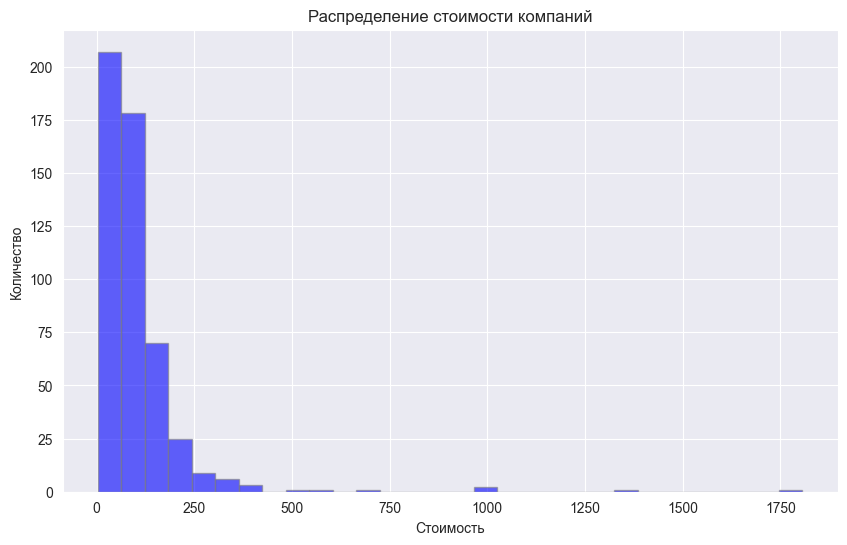

In [19]:
# 1. Смотрим на распределение стоимости
plt.figure(figsize=(10, 6))
plt.hist(y, bins=30, alpha=0.6, color="blue", edgecolor="gray", linewidth=1)
plt.title("Распределение стоимости компаний")
plt.xlabel("Стоимость")
plt.ylabel("Количество")
plt.show()

## Анализ корреляций

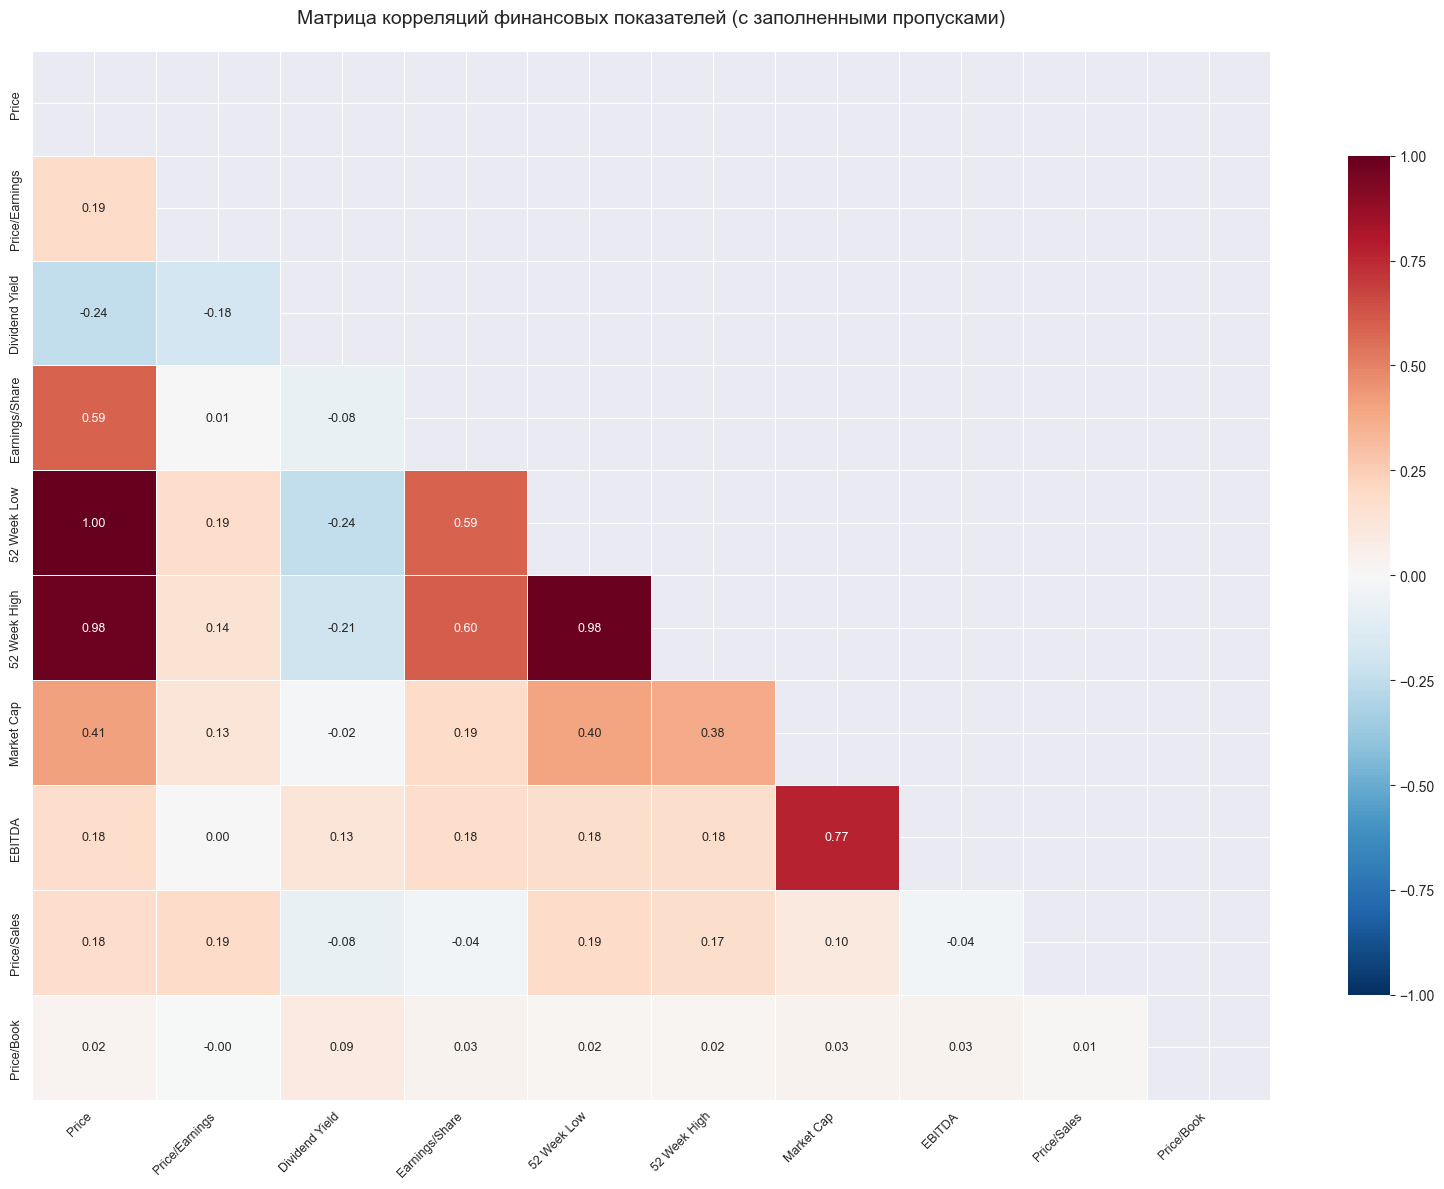

In [24]:
# 2. Смотрим корреляции (взаимосвязи между переменными)
plt.figure(figsize=(16, 12))

# Создаем копию и выбираем числовые колонки
financials_numeric = financials_csv.select_dtypes(include=[np.number]).copy()

# Заполняем пропуски медианными значениями (можно изменить на mean или другое)
financials_filled = financials_numeric.fillna(financials_numeric.median())

# Или удаляем колонки с большим количеством пропусков
# threshold = 0.3  # удаляем колонки с >30% пропусков
# financials_clean = financials_numeric.dropna(axis=1, thresh=int(len(financials_numeric) * (1-threshold)))

# Считаем корреляции
correlation_matrix = financials_filled.corr()

# Создаем heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # маска для верхнего треугольника

sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap="RdBu_r",
            linewidths=0.5, linecolor="white", annot_kws={"size": 9},
            fmt='.2f', center=0, vmin=-1, vmax=1,
            cbar_kws={'shrink': 0.8})

plt.title("Матрица корреляций финансовых показателей (с заполненными пропусками)", fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

# Анализ конкретных колонок

In [25]:
print("Статистика по проблемным колонкам:")
problem_columns = ['52 Week Low', '52 Week High', 'Price/Sales', 'Price/Book']

for col in problem_columns:
    if col in financials_csv.columns:
        print(f"\n{col}:")
        print(f"  Пропусков: {financials_csv[col].isnull().sum()} ({financials_csv[col].isnull().mean()*100:.1f}%)")
        print(f"  Уникальных значений: {financials_csv[col].nunique()}")
        if financials_csv[col].notna().any():
            print(f"  Диапазон: {financials_csv[col].min():.2f} - {financials_csv[col].max():.2f}")

Статистика по проблемным колонкам:

52 Week Low:
  Пропусков: 0 (0.0%)
  Уникальных значений: 501
  Диапазон: 6.59 - 2067.99

52 Week High:
  Пропусков: 0 (0.0%)
  Уникальных значений: 495
  Диапазон: 2.80 - 1589.00

Price/Sales:
  Пропусков: 0 (0.0%)
  Уникальных значений: 505
  Диапазон: 0.15 - 20.09

Price/Book:
  Пропусков: 8 (1.6%)
  Уникальных значений: 391
  Диапазон: 0.51 - 1403.38


## Отбор значимых признаков

In [27]:
# 3. Смотрим на самые важные признаки для стоимости
correlation_with_cost = correlation_matrix["Price"].sort_values(ascending=False)
print("\nКорреляция признаков со стоимостью:")
print(correlation_with_cost)


Корреляция признаков со стоимостью:
Price             1.000000
52 Week Low       0.995076
52 Week High      0.982787
Earnings/Share    0.591061
Market Cap        0.406474
Price/Earnings    0.194861
Price/Sales       0.181625
EBITDA            0.180321
Price/Book        0.023681
Dividend Yield   -0.244630
Name: Price, dtype: float64


# Базовая модель

## Визуализируем топ-10 признаков по корреляции со стоимостью

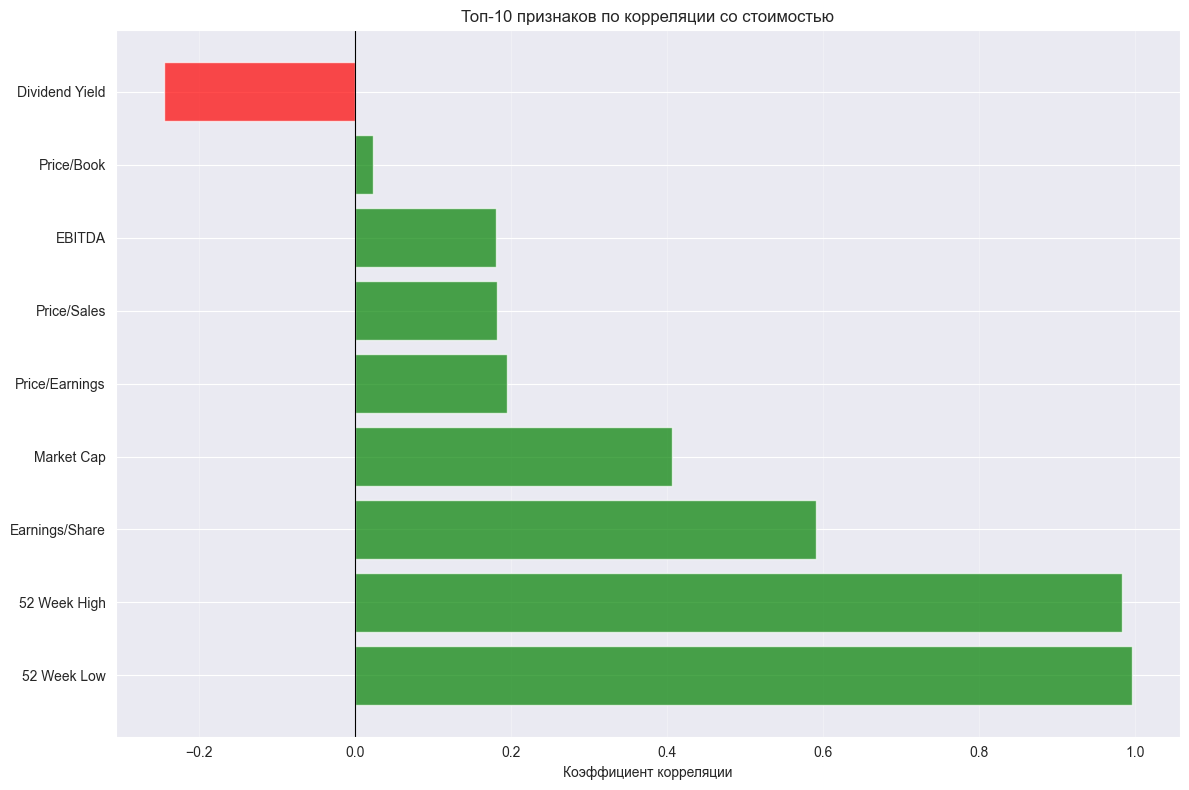

In [29]:
plt.figure(figsize=(12, 8))
top_correlations = correlation_with_cost.drop("Price").head(10)
colors = ['green' if x > 0 else 'red' for x in top_correlations.values]
plt.barh(range(len(top_correlations)), top_correlations.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_correlations)), top_correlations.index)
plt.xlabel("Коэффициент корреляции")
plt.title("Топ-10 признаков по корреляции со стоимостью")
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Делим данные для обучения и теста

In [30]:

# Возьмем 80% для обучения, 20% для тестирования
# random_state=42 для того чтобы результат можно было повторить
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Размер тренировочного набора: {X_train.shape[0]} примеров")
print(f"Размер тестового набора: {X_test.shape[0]} примеров")
print(f"Количество признаков: {X_train.shape[1]}")

Размер тренировочного набора: 404 примеров
Размер тестового набора: 101 примеров
Количество признаков: 12


## Нормализуем данные

In [37]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

# Выбираем числовые колонки
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

print(f"Исходные колонки: \n{list(X_train_numeric.columns)}")

# 1. Заполняем пропуски
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train_numeric)
X_test_imputed = imputer.transform(X_test_numeric)

# 2. Удаляем признаки с нулевой дисперсией
selector = VarianceThreshold(threshold=0.01)
X_train_selected = selector.fit_transform(X_train_imputed)
X_test_selected = selector.transform(X_test_imputed)

# Получаем названия оставшихся колонок
selected_columns = X_train_numeric.columns[selector.get_support()]
print(f"\nКолонки после удаления нулевой дисперсии: \n{list(selected_columns)}")

# 3. Нормализуем
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

print("\nРезультат нормализации:")
print(f"Среднее значение: {X_train_scaled.mean(axis=0).round(4)}")
print(f"Стандартное отклонение: {X_train_scaled.std(axis=0).round(4)}")
print(f"Размерность данных: {X_train_scaled.shape}")

Исходные колонки: 
['Price/Earnings', 'Dividend Yield', 'Earnings/Share', '52 Week Low', '52 Week High', 'Market Cap', 'EBITDA', 'Price/Sales', 'Price/Book']

Колонки после удаления нулевой дисперсии: 
['Price/Earnings', 'Dividend Yield', 'Earnings/Share', '52 Week Low', '52 Week High', 'Market Cap', 'EBITDA', 'Price/Sales', 'Price/Book']

Результат нормализации:
Среднее значение: [-0. -0. -0.  0.  0. -0.  0.  0. -0.]
Стандартное отклонение: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Размерность данных: (404, 9)


# Baseline модели

In [38]:
# Создаем и обучаем модель линейной регрессии
baseline_model = LinearRegression()

# Обучаем на нормализованных тренировочных данных
baseline_model.fit(X_train_scaled, y_train)

# Проверяем на тренировочном и тестовом наборах
y_train_pred = baseline_model.predict(X_train_scaled)
y_test_pred = baseline_model.predict(X_test_scaled)

print(f"\nКоэффициенты модели (первые 5):")
for i in range(min(5, len(baseline_model.coef_))):
    print(f"  {X_train.columns[i]}: {baseline_model.coef_[i]:.4f}")
print(f"\nКонстанта модели: {baseline_model.intercept_:.4f}")


Коэффициенты модели (первые 5):
  Name: 0.8535
  Sector: -1.9669
  Price/Earnings: 2.6436
  Dividend Yield: 90.8318
  Earnings/Share: 36.7049

Константа модели: 104.8121


In [39]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\nМетрики на тренировочном наборе:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE: {train_mae:.4f}")

print(f"\nМетрики на тестовом наборе:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")


Метрики на тренировочном наборе:
  RMSE: 12.7156
  MAE: 6.4783

Метрики на тестовом наборе:
  RMSE: 17.6584
  MAE: 6.8663


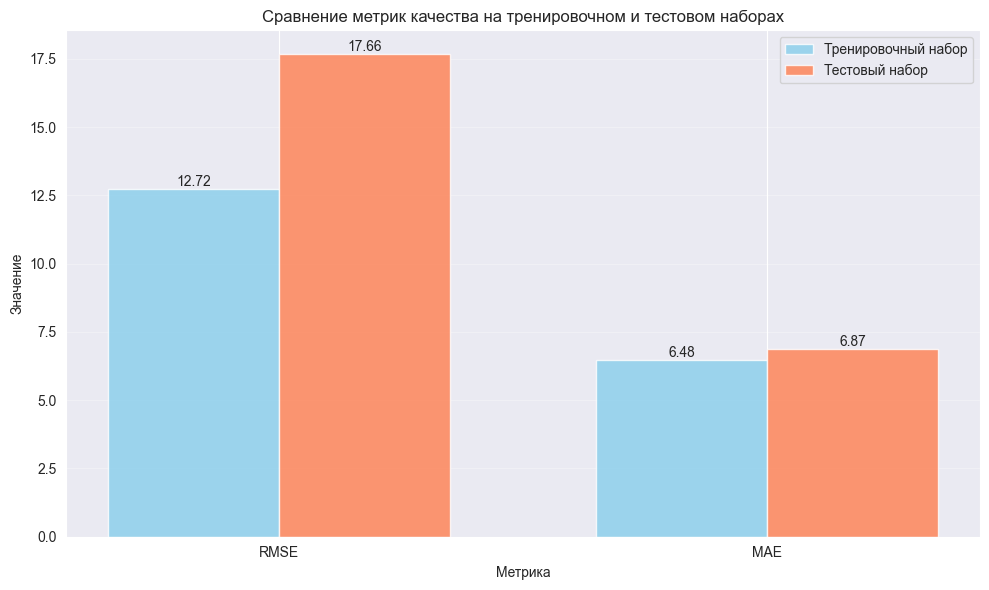

In [40]:
# Сравнение метрик на тренировочном и тестовом наборах
metrics_data = {
    'RMSE': [train_rmse, test_rmse],
    'MAE': [train_mae, test_mae]
}

fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(metrics_data))
width = 0.35

bars1 = ax.bar(x_pos - width/2, [metrics_data[m][0] for m in metrics_data], width, 
               label='Тренировочный набор', alpha=0.8, color='skyblue')
bars2 = ax.bar(x_pos + width/2, [metrics_data[m][1] for m in metrics_data], width,
               label='Тестовый набор', alpha=0.8, color='coral')

ax.set_xlabel('Метрика')
ax.set_ylabel('Значение')
ax.set_title('Сравнение метрик качества на тренировочном и тестовом наборах')
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics_data.keys())
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Значения над столбками
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()